In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker
import os
%matplotlib inline

In [2]:
datFileName = "../data/processedSaps-new.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ')
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
sapsDataDF = pandas.concat( [ sapsDataDF, \
                    pandas.cut( sapsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
sapsDataDF.columns = [ ["dateStr", "hour","sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat",\
                     "poesMLT", "dst_date", "dst_index", "time", "dst_bin"] ]
# get a csv file with fewer columns for getting grid file data
sapsDataCsv = sapsDataDF[ ["dateStr", "sapsLat", "sapsMLT", "radId", "time"] ]
sapsDataCsv.to_csv("../data/data_for_grid.txt", sep=' ', index=False)
# sapsDataDF["time"] = sapsRawDF["date"].map(lambda x: x.strftime('%H%M'))
sapsDataDF.head()

,dateStr,hour,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time,dst_bin
0,20110107,0,56.5,17.7543,308.2077,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
1,20110107,0,55.5,18.0147,224.1588,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
2,20110107,0,56.5,17.8749,307.4328,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
3,20110107,0,55.5,18.1324,222.4787,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
4,20110107,0,56.5,17.9955,305.4201,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"


In [3]:
grdFileName = "../data/gridVecs.txt"
prcsdGrdFileName = "../data/gridVecs-processed.txt"
# os.system( 'cat ' + grdFileName + ' | tr -s "  " > ' + "../data/gridVecs-processed.txt" )
inpColNames = [ "dateStr", "time", "sapsLat", "sapsLon", \
          "grdVelMagn", "grdVelAzim", "radId", "sapsMLT"]
gridVecsDF = pandas.read_csv(prcsdGrdFileName, sep=' ',\
                             header=None, names=inpColNames)
gridVecsDF.head()

,dateStr,time,sapsLat,sapsLon,grdVelMagn,grdVelAzim,radId,sapsMLT
0,20110107,0,56.5,344.6231,83.6037,-47.4307,33,17.7543
1,20110107,0,55.5,348.5294,96.6077,-42.6488,33,18.0147
2,20110107,0,56.5,346.4322,84.6154,-44.5228,33,17.8749
3,20110107,0,55.5,350.2941,95.6795,-35.1175,33,18.1324
4,20110107,0,56.5,348.2412,84.6160,-39.3513,33,17.9955


In [4]:
# Merge the grid vectors DF and saps data DF
print "saps DF size-->", sapsDataDF.shape
print "grid DF size before merge-->", gridVecsDF.shape
gridVecsDF = pandas.merge( gridVecsDF, sapsDataDF,\
                          on=[ "dateStr", "time", "sapsLat", "radId", "sapsMLT" ] )
print "grid DF size after merge-->", gridVecsDF.shape

saps DF size--> (173136, 12)
grid DF size before merge--> (167653, 8)
grid DF size after merge--> (163444, 15)


In [5]:
# Assuming a perfectly westward flow for SAPS 
# estimate the velocities inside the channel
sapsAzim = -90.
gridVecsDF["estSapsVels"] = numpy.abs( gridVecsDF["grdVelMagn"]/ numpy.cos( \
                                numpy.deg2rad( sapsAzim - gridVecsDF["grdVelAzim"] ) ) )
# only consider L-o-S velocities greater than 100 m/s
gridVecsDF = gridVecsDF[ gridVecsDF["grdVelMagn"] >= 100. ].reset_index(drop=True)
# filter out all vectors where velocities are greater than 2000 m/s
gridVecsDF["sapsMLTRounded"] = gridVecsDF["sapsMLT"].map(lambda x: round(x) )
gridVecsDF = gridVecsDF[ gridVecsDF["estSapsVels"] <= 2500.].reset_index(drop=True)
gridVecsDF.head()

,dateStr,time,sapsLat,sapsLon,grdVelMagn,grdVelAzim,radId,sapsMLT,hour,sapsVel,poesLat,poesMLT,dst_date,dst_index,dst_bin,estSapsVels,sapsMLTRounded
0,20110107,0,59.5,343.2787,517.6003,-43.2727,33,17.6647,0,404.4858,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",755.101113,18.0
1,20110107,0,57.5,349.7409,104.1324,-30.7649,33,18.0955,0,368.7867,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",203.575813,18.0
2,20110107,0,59.5,345.2459,519.2540,-37.6651,33,17.7958,0,405.7251,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",849.780327,18.0
3,20110107,0,58.5,349.4681,108.4252,-28.0684,33,18.0773,0,404.4406,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",230.434370,18.0
4,20110107,0,57.5,351.6062,124.2545,-23.8893,33,18.2199,0,363.6906,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",306.823324,18.0


In [6]:
# filter out unwanted data
# Basically those where prob of occ is very less
dstGrps = gridVecsDF.groupby(["dst_bin", "sapsMLTRounded", "sapsLat"])
dstSapsMLTLatCountDF = pandas.DataFrame( dstGrps["sapsVel"].count() ).reset_index()
maxCntMLTLatDst = dstSapsMLTLatCountDF.groupby(["dst_bin"]).max().reset_index()
maxCntMLTLatDst = maxCntMLTLatDst.drop(["sapsMLTRounded", "sapsLat"], 1)
maxCntMLTLatDst.columns = ["dst_bin", "maxCount"]
dstSapsMLTLatCountDF = pandas.merge( dstSapsMLTLatCountDF, maxCntMLTLatDst, \
                              on=["dst_bin"], how='inner')
dstSapsMLTLatCountDF.columns = ["dst_bin", "sapsMLT", "sapsLat", "dataCount", "maxCount"]
dstSapsMLTLatCountDF["probOcc"] = dstSapsMLTLatCountDF["dataCount"]/dstSapsMLTLatCountDF["maxCount"]
dstSapsMLTLatCountDF = dstSapsMLTLatCountDF[ ["dst_bin", "sapsMLT", "sapsLat", "probOcc"] ]
dstSapsMLTLatCountDF.head()

,dst_bin,sapsMLT,sapsLat,probOcc
0,"(-10, 10]",0.0,50.5,0.001357
1,"(-10, 10]",0.0,54.5,0.002714
2,"(-10, 10]",0.0,55.5,0.013569
3,"(-10, 10]",0.0,56.5,0.035278
4,"(-10, 10]",0.0,57.5,0.107191


In [7]:
velLocGrps = gridVecsDF.groupby(\
                ["dst_bin", "sapsMLTRounded", "sapsLat"])
maxVelLoc = velLocGrps["estSapsVels"].max()
medianVelLoc = velLocGrps["estSapsVels"].median()
meanVelLoc = velLocGrps["estSapsVels"].mean()
stdVelLoc = velLocGrps["estSapsVels"].std()
velLocDF = pandas.concat([ maxVelLoc, medianVelLoc, \
                          meanVelLoc, stdVelLoc], axis=1).reset_index()
velLocDF.columns = [ "dst_bin", "sapsMLT", \
                    "sapsLat", "max_vel", "med_vel",\
                    "mean_vel", "std_vel"]
velLocDF['normMLT'] = [x-24 if x >= 12 else x for x in velLocDF['sapsMLT']]
# merge with mostlikely location DF to choose only the
# DF where prob of Occ is gt 0.25
velLocDF = pandas.merge( velLocDF, dstSapsMLTLatCountDF,
                              on=["dst_bin", "sapsMLT", "sapsLat"] )
# Only choose locations where probOcc > 0.25
velLocDF = velLocDF[ velLocDF["probOcc"] > 0.25 ]
# We'll only take in median velocity
velLocDF = velLocDF[ [ "dst_bin", "sapsMLT", "sapsLat", \
                    "med_vel", "normMLT", "probOcc" ] ]
velLocDF.columns = [ "dst_bin", "sapsMLT", "sapsLat", \
                    "sapsVel", "normMLT", "probOcc" ]
velLocDF.head()

,dst_bin,sapsMLT,sapsLat,sapsVel,normMLT,probOcc
6,"(-10, 10]",0.0,59.5,301.334863,0.0,0.306649
7,"(-10, 10]",0.0,60.5,301.017709,0.0,0.363636
8,"(-10, 10]",0.0,61.5,315.406230,0.0,0.394844
9,"(-10, 10]",0.0,62.5,346.869158,0.0,0.344640
17,"(-10, 10]",1.0,57.5,302.584951,1.0,0.293080


In [8]:
# get the velocity data in a text file to plot it on a map using IDL
velLocDFFile = velLocDF
def set_dst_median(row):
    if row["dst_bin"] == "(-10, 10]":
        return -5.
    elif row["dst_bin"] == "(-25, -10]":
        return -18.
    elif row["dst_bin"] == "(-50, -25]":
        return -36.
    elif row["dst_bin"] == "(-75, -50]":
        return -57.
    else:
        return -95.

velLocDFFile["dst_median"] = velLocDFFile.apply (lambda row: set_dst_median(row),axis=1)
velLocDFFile = velLocDFFile[ ["sapsMLT", "sapsLat", \
                              "sapsVel", "normMLT", "probOcc", "dst_median"] ]
velLocDFFile.to_csv("../data/sapsVels.txt", sep=' ', index=False)
velLocDFFile.head(5)

,sapsMLT,sapsLat,sapsVel,normMLT,probOcc,dst_median
6,0.0,59.5,301.334863,0.0,0.306649,-5.0
7,0.0,60.5,301.017709,0.0,0.363636,-5.0
8,0.0,61.5,315.406230,0.0,0.394844,-5.0
9,0.0,62.5,346.869158,0.0,0.344640,-5.0
17,1.0,57.5,302.584951,1.0,0.293080,-5.0


In [9]:
# Get peak SAPS Velocities vs MLT plots
vestatsSapsGrp = velLocDF.groupby(["dst_bin", "sapsMLT"])
meanVelSer = vestatsSapsGrp["sapsVel"].mean()
stdVelSer = vestatsSapsGrp["sapsVel"].std()
maxVelSer = vestatsSapsGrp["sapsVel"].max()
# merge the two Series into a DF
velstatsSapsDF = pandas.concat([ meanVelSer, stdVelSer, maxVelSer], axis=1).reset_index()
velstatsSapsDF.columns = [ "dst_bin", "sapsMLT", "mean_vel", "std_vel", "max_vel" ]
velstatsSapsDF['normMLT'] = [x-24 if x >= 12 else x for x in velstatsSapsDF['sapsMLT']]
velstatsSapsDF.head()

,dst_bin,sapsMLT,mean_vel,std_vel,max_vel,normMLT
0,"(-10, 10]",0.0,316.156990,21.546030,346.869158,0.0
1,"(-10, 10]",1.0,315.170827,20.692970,345.041375,1.0
2,"(-10, 10]",2.0,320.186904,11.120812,330.023087,2.0
3,"(-10, 10]",20.0,387.828387,32.070207,419.212877,-4.0
4,"(-10, 10]",21.0,418.713949,11.246934,435.403483,-3.0


In [10]:
# Fit a straight line to each of the dst bins
def linear_func(x, slope, intrcpt):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return intrcpt + slope*x

initGuess = ( 10., 10. )

fitDF1010 = velstatsSapsDF[ velstatsSapsDF[ "dst_bin" ] == "(-10, 10]" ]
fitDF2510 = velstatsSapsDF[ velstatsSapsDF[ "dst_bin" ] == "(-25, -10]" ]
fitDF5025 = velstatsSapsDF[ velstatsSapsDF[ "dst_bin" ] == "(-50, -25]" ]
fitDF7550 = velstatsSapsDF[ velstatsSapsDF[ "dst_bin" ] == "(-75, -50]" ]
fitDF15075 = velstatsSapsDF[ velstatsSapsDF[ "dst_bin" ] == "(-150, -75]" ]

popt1010, pcov1010 = curve_fit(linear_func, \
                        fitDF1010['normMLT'].T,\
                        fitDF1010['mean_vel'].T,
                       p0=initGuess)

popt2510, pcov2510 = curve_fit(linear_func, \
                        fitDF2510['normMLT'].T,\
                        fitDF2510['mean_vel'].T,
                       p0=initGuess)

popt5025, pcov5025 = curve_fit(linear_func, \
                        fitDF5025['normMLT'].T,\
                        fitDF5025['mean_vel'].T,
                       p0=initGuess)

popt7550, pcov7550 = curve_fit(linear_func, \
                        fitDF7550['normMLT'].T,\
                        fitDF7550['mean_vel'].T,
                       p0=initGuess)

popt15075, pcov15075 = curve_fit(linear_func, \
                        fitDF15075['normMLT'].T,\
                        fitDF15075['mean_vel'].T,
                       p0=initGuess)

# Now get data from the fits
normMLTModel1010 = range( int( numpy.min(fitDF1010['normMLT']) ), int( numpy.max(fitDF1010['normMLT']) ) + 1, 1)
velArrModel1010 = [ round( linear_func(t, popt1010[0], popt1010[1]) ) for t in normMLTModel1010 ]

normMLTModel2510 = range( int( numpy.min(fitDF2510['normMLT']) ), int( numpy.max(fitDF2510['normMLT']) ) + 1, 1)
velArrModel2510 = [ round( linear_func(t, popt2510[0], popt2510[1]) ) for t in normMLTModel2510 ]

normMLTModel5025 = range( int( numpy.min(fitDF5025['normMLT']) ), int( numpy.max(fitDF5025['normMLT']) ) + 1, 1)
velArrModel5025 = [ round( linear_func(t, popt5025[0], popt5025[1]) ) for t in normMLTModel5025 ]

normMLTModel7550 = range( int( numpy.min(fitDF7550['normMLT']) ), int( numpy.max(fitDF7550['normMLT']) ) + 1, 1)
velArrModel7550 = [ round( linear_func(t, popt7550[0], popt7550[1]) ) for t in normMLTModel7550 ]

normMLTModel15075 = range( int( numpy.min(fitDF15075['normMLT']) ), int( numpy.max(fitDF15075['normMLT']) ) + 1, 1)
velArrModel15075 = [ round( linear_func(t, popt15075[0], popt15075[1]) ) for t in normMLTModel15075 ]

In [19]:
# get the linear equations for the fitted velocities as string to note them on plots.
strVel15075 = "Vel = " + str( int(round( popt15075[1] ) ) ) + " + (" + str( int( round( popt15075[0] ) ) )  + ") x $MLT_{Norm}$"
strVel7550 = "Vel = " + str( int( round( popt7550[1] ) ) ) + " + (" + str( int( round( popt7550[0] ) ) )  + ") x $MLT_{Norm}$"
strVel5025 = "Vel = " + str( int( round( popt5025[1] ) ) ) + " + (" + str( int( round( popt5025[0] ) ) )  + ") x $MLT_{Norm}$"
strVel2510 = "Vel = " + str( int( round( popt2510[1] ) ) ) + " + (" + str( int( round( popt2510[0] ) ) )  + ") x $MLT_{Norm}$"
strVel1010 = "Vel = " + str( int( round( popt1010[1] ) ) ) + " + (" + str( int( round( popt1010[0] ) ) )  + ") x $MLT_{Norm}$"

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


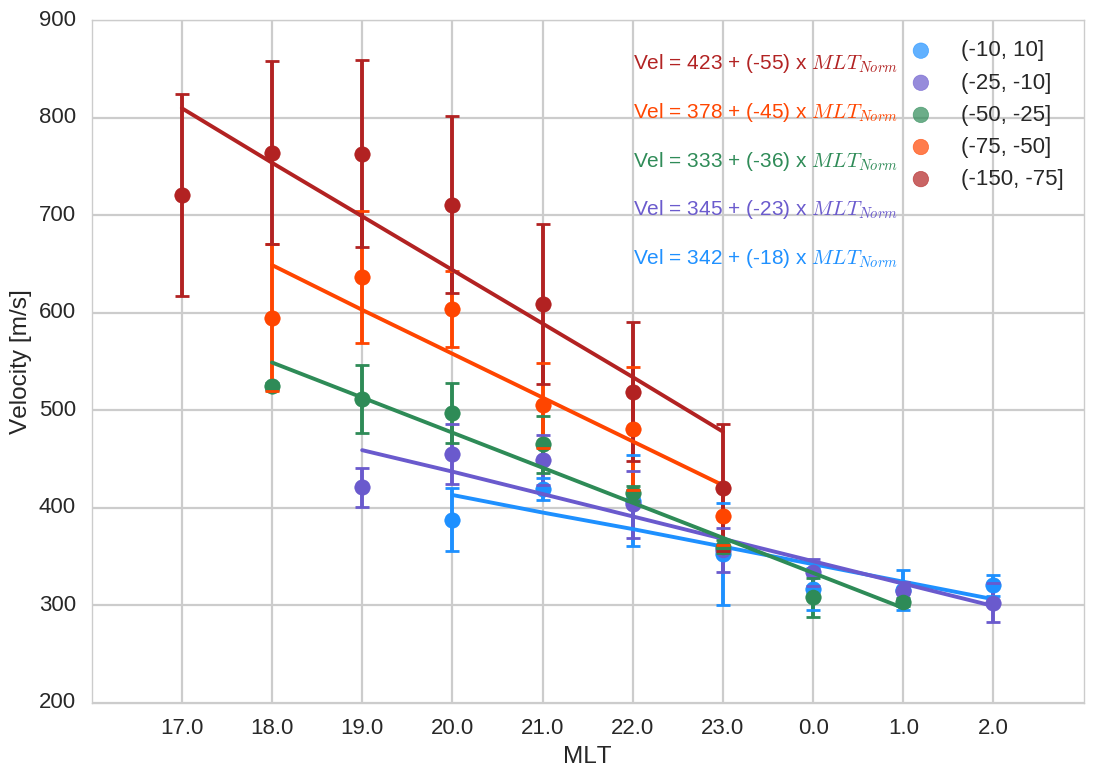

In [22]:
sns.set_style("whitegrid")
sns.set_context("poster")

velstatsSapsDF['normMLT'] = [x-24 if x >= 12 else x for x in velstatsSapsDF['sapsMLT']]
velstatsSapsDF["std_vel"] = velstatsSapsDF["std_vel"].fillna(20.)
velstatsSapsDF = velstatsSapsDF.sort(["normMLT"])
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######

plt.scatter(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-10, 10]"],
            velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-10, 10]"],\
             velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-10, 10]"],\
             yerr=velstatsSapsDF['std_vel'][velstatsSapsDF['dst_bin'] == "(-10, 10]"], \
             color='dodgerblue', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel1010, velArrModel1010, color='dodgerblue' )

plt.xticks(velstatsSapsDF['normMLT'].unique(), \
           velstatsSapsDF['sapsMLT'].unique(), size='small')

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
plt.scatter(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-25, -10]"],
            velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
plt.errorbar(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-25, -10]"],\
             velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-25, -10]"],\
             yerr=velstatsSapsDF['std_vel'][velstatsSapsDF['dst_bin'] == "(-25, -10]"], \
             color='slateblue', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel2510, velArrModel2510, color='slateblue' )

plt.xticks(velstatsSapsDF['normMLT'].unique(), \
           velstatsSapsDF['sapsMLT'].unique(), size='small')
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######



# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######

plt.scatter(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-50, -25]"],
            velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
plt.errorbar(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-50, -25]"],\
             velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-50, -25]"],\
             yerr=velstatsSapsDF['std_vel'][velstatsSapsDF['dst_bin'] == "(-50, -25]"], \
             color='seagreen', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel5025, velArrModel5025, color='seagreen' )

plt.xticks(velstatsSapsDF['normMLT'].unique(), \
           velstatsSapsDF['sapsMLT'].unique(), size='small')
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######



# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-75, -50]"],
            velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
plt.errorbar(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-75, -50]"],\
             velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-75, -50]"],\
             yerr=velstatsSapsDF['std_vel'][velstatsSapsDF['dst_bin'] == "(-75, -50]"], \
             color='orangered', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel7550, velArrModel7550, color='orangered' )

plt.xticks(velstatsSapsDF['normMLT'].unique(), \
           velstatsSapsDF['sapsMLT'].unique(), size='small')

# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######



# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-150, -75]"],
            velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-150, -75]')
plt.errorbar(velstatsSapsDF['normMLT'][velstatsSapsDF['dst_bin'] == "(-150, -75]"],\
             velstatsSapsDF['mean_vel'][velstatsSapsDF['dst_bin'] == "(-150, -75]"],\
             yerr=velstatsSapsDF['std_vel'][velstatsSapsDF['dst_bin'] == "(-150, -75]"], \
             color='firebrick', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel15075, velArrModel15075, color='firebrick' )

plt.xticks(velstatsSapsDF['normMLT'].unique(), \
           velstatsSapsDF['sapsMLT'].unique(), size='small')

plt.text(-2., 850., strVel15075, fontsize=15, color='firebrick')
plt.text(-2., 800., strVel7550, fontsize=15, color='orangered')
plt.text(-2., 750., strVel5025, fontsize=15, color='seagreen')
plt.text(-2., 700., strVel2510, fontsize=15, color='slateblue')
plt.text(-2., 650., strVel1010, fontsize=15, color='dodgerblue')

# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-8,3] )
# plt.ylim( [0,1000] )
plt.xlabel("MLT")
plt.ylabel("Velocity [m/s]")
plt.legend()
plt.savefig("../figs/meanVelMLT-std.pdf",bbox_inches='tight')

In [13]:
# get the latitudinal variation in peak velocity 
peakVelMLT = velLocDF.groupby( ["dst_bin", "sapsMLT"] )["sapsVel"].max().reset_index()
peakVelMLT = pandas.merge( peakVelMLT, velLocDF, on=["dst_bin", "sapsMLT", "sapsVel"] )
peakVelMLT[ peakVelMLT["dst_bin"] == "(-75, -50]" ].head(20)

,dst_bin,sapsMLT,sapsVel,sapsLat,normMLT,probOcc,dst_median
30,"(-75, -50]",18.0,708.517729,58.5,-6.0,0.279592,-57.0
31,"(-75, -50]",19.0,716.611504,57.5,-5.0,0.489796,-57.0
32,"(-75, -50]",20.0,657.056264,56.5,-4.0,0.738776,-57.0
33,"(-75, -50]",21.0,551.932648,57.5,-3.0,0.987755,-57.0
34,"(-75, -50]",22.0,553.842848,58.5,-2.0,0.579592,-57.0
35,"(-75, -50]",23.0,425.222828,58.5,-1.0,0.297959,-57.0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


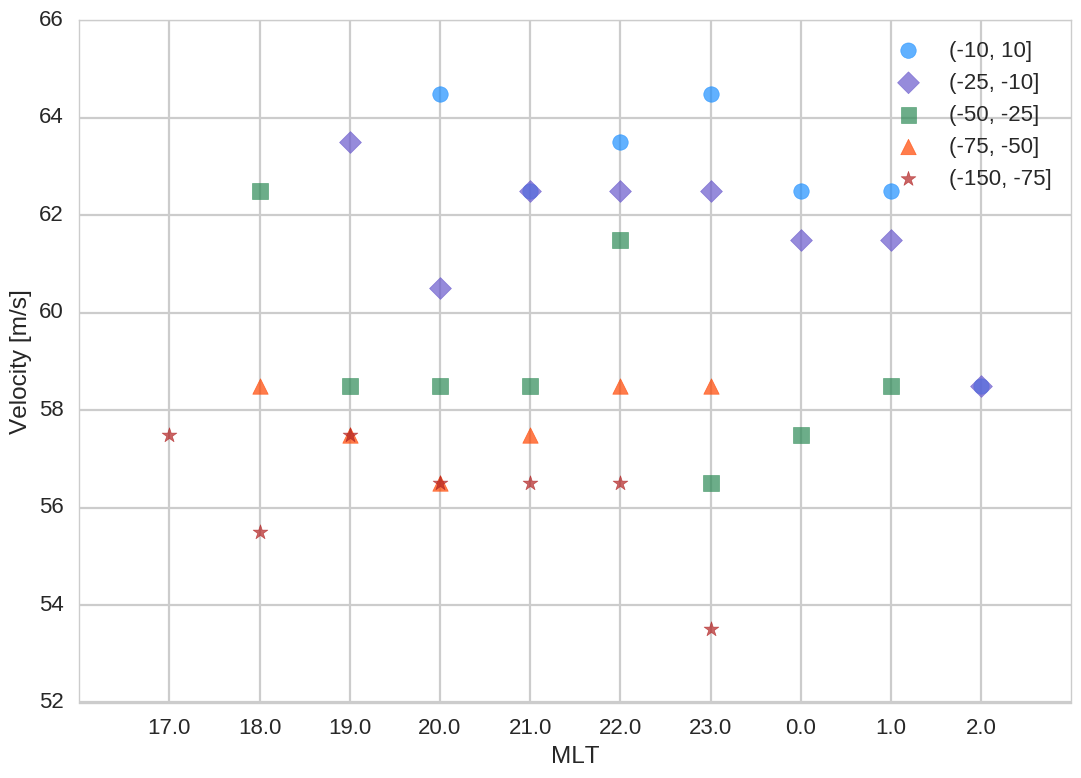

In [14]:
sns.set_style("whitegrid")
sns.set_context("poster")

# peakVelMLT['normMLT'] = [x-24 if x >= 12 else x for x in peakVelMLT['sapsMLT']]
peakVelMLT = peakVelMLT.sort(["normMLT"])
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######

plt.scatter(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-10, 10]"],
            peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
# plt.errorbar(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-10, 10]"],\
#              peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-10, 10]"],\
#              yerr=peakVelMLT['std_vel'][peakVelMLT['dst_bin'] == "(-10, 10]"], \
#              color='dodgerblue', label='', capthick=2., capsize=5.)
plt.xticks(peakVelMLT['normMLT'].unique(), \
           peakVelMLT['sapsMLT'].unique(), size='small')

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
plt.scatter(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-25, -10]"],
            peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-25, -10]"],
            marker='D',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
# plt.errorbar(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-25, -10]"],\
#              peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-25, -10]"],\
#              yerr=peakVelMLT['std_vel'][peakVelMLT['dst_bin'] == "(-25, -10]"], \
#              color='slateblue', label='', capthick=2., capsize=5.)
plt.xticks(peakVelMLT['normMLT'].unique(), \
           peakVelMLT['sapsMLT'].unique(), size='small')
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######
# ###### PLOT Dst-bin (-25, -10] ######



# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######

plt.scatter(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-50, -25]"],
            peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-50, -25]"],
            marker='s',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
# plt.errorbar(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-50, -25]"],\
#              peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-50, -25]"],\
#              yerr=peakVelMLT['std_vel'][peakVelMLT['dst_bin'] == "(-50, -25]"], \
#              color='seagreen', label='', capthick=2., capsize=5.)
plt.xticks(peakVelMLT['normMLT'].unique(), \
           peakVelMLT['sapsMLT'].unique(), size='small')
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######
# ###### PLOT Dst-bin (-50, -25] ######



# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######
# # ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-75, -50]"],
            peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-75, -50]"],
            marker='^',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
# plt.errorbar(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-75, -50]"],\
#              peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-75, -50]"],\
#              yerr=peakVelMLT['std_vel'][peakVelMLT['dst_bin'] == "(-75, -50]"], \
#              color='orangered', label='', capthick=2., capsize=5.)
plt.xticks(peakVelMLT['normMLT'].unique(), \
           peakVelMLT['sapsMLT'].unique(), size='small')

# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######



# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-150, -75]"],
            peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-150, -75]"],
            marker='*',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-150, -75]')
# plt.errorbar(peakVelMLT['normMLT'][peakVelMLT['dst_bin'] == "(-150, -75]"],\
#              peakVelMLT['sapsLat'][peakVelMLT['dst_bin'] == "(-150, -75]"],\
#              yerr=peakVelMLT['std_vel'][peakVelMLT['dst_bin'] == "(-150, -75]"], \
#              color='firebrick', label='', capthick=2., capsize=5.)
plt.xticks(peakVelMLT['normMLT'].unique(), \
           peakVelMLT['sapsMLT'].unique(), size='small')

# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
# # ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-8,3] )
plt.xlabel("MLT")
plt.ylabel("Velocity [m/s]")
plt.legend()
plt.savefig("../figs/peakVelLoc.pdf",bbox_inches='tight')